In [2]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

import sys
from os.path import dirname, join, abspath

from brainmodel_utils.neural_mappers.utils import convert_dict_to_tuple
from brainmodel_utils.metrics.consistency import get_linregress_consistency

sys.path.insert(0, abspath(join(dirname("utils.py"), '..')))
from zfa.data_comparisons.utils import load_data_tensors

sys.path.insert(0, abspath(join(dirname("rdk_bang_bang.py"), '..')))
from scripts.python_scripts.rdk_bang_bang import run_sim, visualize_results

In [3]:
# Simulation parameters
sim_params = {
    'duration': 20000,  # Duration of the whole simulation in ms
    'open_loop_start_and_end_time': [5000 - 1, 9000],  # Open loop start and end times
    'drift_speed': 1,  # Striped bar drift speed
    'motosensory_gain': 2  # Gain from agent swimming power to stripes
}

# Agent parameters
agent_params = {
    'f_integration_tau': 5000,
    'f_integration_decay_constant': 2,
    'f_integration_gain': 10,
    'f_threshold': 1.6,  # Astrocyte activity threshold for giving up
    'gaba_gain':int(1e6),
    'gaba_threshold': 0.1
}

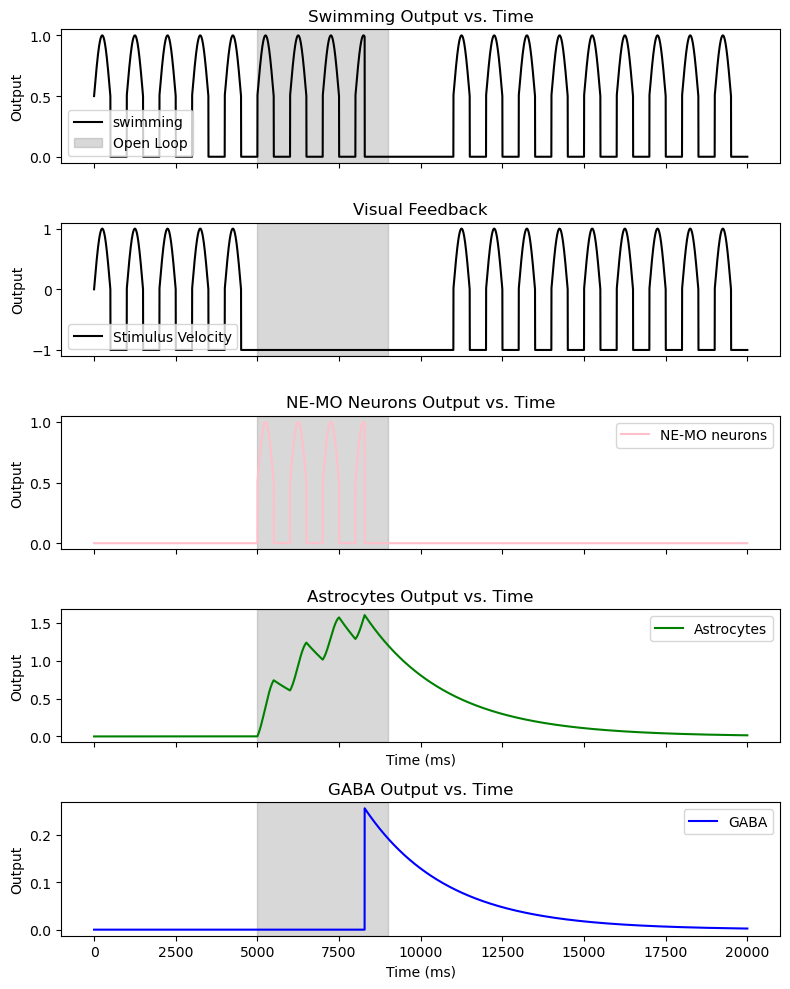

In [4]:
# Run the simulation
results = run_sim(sim_params, agent_params)

# Extract the open loop times
open_loop_start_time, open_loop_end_time = sim_params['open_loop_start_and_end_time']

# Plot results
visualize_results(results, open_loop_start_time, open_loop_end_time)


In [6]:
neural_brain_data, glial_brain_data, _, _, _, _, _, _ = load_data_tensors()

 ---Loading data tensors---  


In [7]:
ANIMALS = list(neural_brain_data.keys())
target_animal = ANIMALS[1]
source_animal = ANIMALS[0]
source_brain_data = glial_brain_data[source_animal]#[:,:,0:1000]
target_brain_data = glial_brain_data[target_animal]#[:,:,0:5000]

In [8]:
results['f_integrator'].shape

(20000,)

(20, 1000)
(20,)


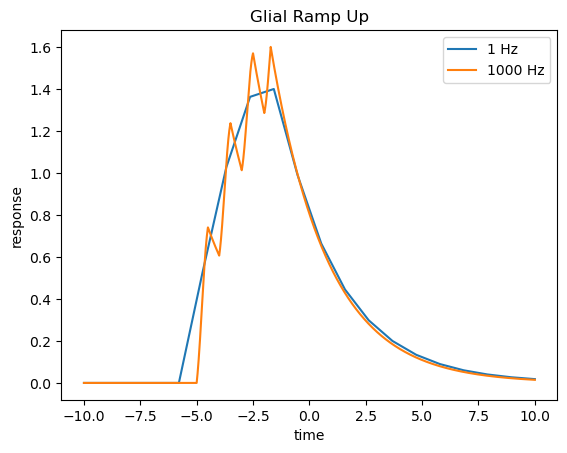

In [9]:
X_1Hz = np.asarray(source_brain_data.coords['time']).reshape(-1, 1)
X_1000Hz = np.linspace(-10, 10, 20000)

glial_ramp = results['f_integrator'].reshape(20, 1000)
print(glial_ramp.shape)
glial_ramp = glial_ramp.mean(axis=1)
print(glial_ramp.shape)
glial_ramp_1000Hz = results['f_integrator']
plt.plot(X_1Hz, glial_ramp, label="1 Hz")
plt.plot(X_1000Hz, results['f_integrator'], label="1000 Hz")
plt.xlabel("time")
plt.ylabel("response")
plt.title("Glial Ramp Up")
plt.legend()

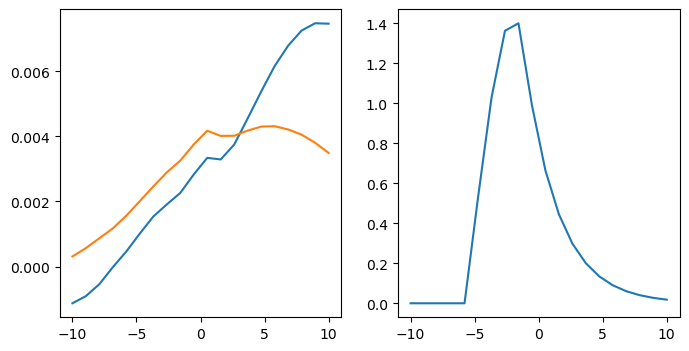

In [10]:
fig = plt.figure(figsize=(8, 4))
mean_time_series_source = np.asarray(source_brain_data.mean(dim = 'trials').mean(dim = 'units'))
mean_time_series_target = np.asarray(target_brain_data.mean(dim = 'trials').mean(dim = 'units'))
glial_ramp_1Hz = results['f_integrator'].reshape(20, 1000)
glial_ramp_1Hz = glial_ramp_1Hz.mean(axis=1)

plt.subplot(1, 2, 1)
plt.plot(X_1Hz, mean_time_series_source)
plt.plot(X_1Hz, mean_time_series_target)

plt.subplot(1, 2, 2)
plt.plot(X_1Hz, glial_ramp_1Hz)
plt.show()

In [11]:
ramp = glial_ramp_1000Hz[open_loop_start_time+1:open_loop_end_time].reshape(20, 1000)
ramp = ramp.mean(axis=1)
ramp.shape

ValueError: cannot reshape array of size 4000 into shape (20,1000)

In [12]:
np.corrcoef(glial_ramp_1Hz, mean_time_series_source)

array([[ 1.        , -0.16074492],
       [-0.16074492,  1.        ]])

In [13]:
mean_time_series_source = np.asarray(source_brain_data.mean(dim = 'trials').mean(dim = 'units'))
std_time_series_source = np.asarray(source_brain_data.mean(dim = 'trials').std(dim = 'units'))
mean_time_series_target = np.asarray(target_brain_data.mean(dim = 'trials').mean(dim = 'units'))
std_time_series_target = np.asarray(target_brain_data.mean(dim = 'trials').std(dim = 'units'))


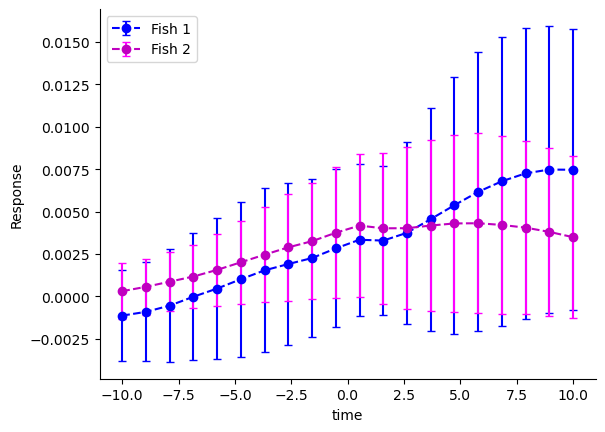

In [27]:
plt.errorbar(X_1Hz, mean_time_series_source, yerr=std_time_series_source, capsize=3, fmt="b--o", ecolor="blue", label='Fish 1')
plt.errorbar(X_1Hz, mean_time_series_target, yerr=std_time_series_target, capsize=3, fmt="m--o", ecolor="magenta", label='Fish 2')
# glial_ramp_1Hz_rescaled = (glial_ramp_1Hz - glial_ramp_1Hz.min()) / (glial_ramp_1Hz.max() - glial_ramp_1Hz.min()) * 0.015 
# plt.plot(X_1Hz, glial_ramp_1Hz_rescaled, color= label="Glial Ramp 1Hz (rescaled)")
plt.legend()
plt.xlabel('time')
plt.ylabel('Response')

# Remove top and right borders
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)